# Ejercicio 3: distribucion Tmedia semanal 

## Analizamos cómo el modelo representa aspectos de la distribución de una variable (Tmedia semanal)

En este tutorial vamos a explorar como es la distribución de probabilidades en el modelo para un dominio reducido:

* Vamos a tomar el mismo set de datos que descargamos
* Vamos a calcular el promedio semanal
* Vamos a calcular la función de distribución de probabilidad y la función de distribución de probabilidad acumulada


In [1]:
# partimos importando los modulos a utilizar:

%matplotlib inline
import xarray as xr
import s3fs
import netCDF4
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import os
import sys
import datetime
from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt


Primero definimos algunas funciones que vamos a usar

In [2]:
# funcion para acomodar xarrays antes de concatenarlos
def preprocess_ds(ds):
    ds['S'] = ds.time.values[0]
    ds['time'] = ds.time.values - ds.time.values[0]
    ds = ds.rename({'time': 'leadtime'})
    return ds
    
# funcion para calcular la CDF de los datos
def calcular_cdf(datos):
    n = len(datos)
    x_ordenados = np.sort(datos)
    cdf = np.arange(1, n + 1) / n
    return x_ordenados, cdf

Vamos a estudiar este comportamiento con el mismo set de variables que ya trabajamos

In [3]:
variable = 'tmean'
lat_n = -20
lat_s = -30
lon_w = -65
lon_e = -55
os.system('mkdir -p ./tmp')
ref_date = datetime.datetime.strptime('20101201', "%Y%m%d")

Abrimos los datos corregidos y sin corregir seleccionamos la semana 2 de pronostico. Hacemos los propio con las observaciones. Aplicamos el promedio semanal

In [4]:
# datos corregidos
ds_corr = xr.open_mfdataset('./tmp/corr_' + variable + '*.nc4', engine='netcdf4', combine='nested', concat_dim=['S'], preprocess=preprocess_ds)
# selecciono semana 2 (8-14 dias)
ds_corr_w2 = ds_corr.sel(leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D'))).mean('leadtime', skipna=True).compute()
print(ds_corr_w2)

<xarray.Dataset>
Dimensions:  (lat: 41, lon: 41, S: 462)
Coordinates:
  * lat      (lat) float64 -20.0 -20.25 -20.5 -20.75 ... -29.5 -29.75 -30.0
  * lon      (lon) float64 -65.0 -64.75 -64.5 -64.25 ... -55.5 -55.25 -55.0
  * S        (S) datetime64[ns] 2010-12-01 2010-12-01 ... 2019-12-25 2019-12-25
Data variables:
    tmean    (S, lat, lon) float64 13.36 14.42 14.86 17.88 ... 28.48 28.38 28.35


In [5]:
# datos sin corregir
ds_uncal = xr.open_mfdataset('./tmp/uncal_' + variable + '*.nc4', engine='netcdf4', combine='nested', concat_dim=['S'], preprocess=preprocess_ds)
# selecciono semana 2 (8-14 dias)
ds_uncal_w2 = ds_uncal.sel(leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D'))).mean('leadtime', skipna=True)
print(ds_uncal_w2)

<xarray.Dataset>
Dimensions:  (lat: 41, lon: 41, S: 462)
Coordinates:
  * lat      (lat) float64 -20.0 -20.25 -20.5 -20.75 ... -29.5 -29.75 -30.0
  * lon      (lon) float64 -65.0 -64.75 -64.5 -64.25 ... -55.5 -55.25 -55.0
  * S        (S) datetime64[ns] 2010-12-01 2010-12-01 ... 2019-12-25 2019-12-25
Data variables:
    tmean    (S, lat, lon) float64 dask.array<chunksize=(1, 41, 41), meta=np.ndarray>


In [6]:
ds_era = xr.open_mfdataset('./tmp/' + variable + '_era5_' + '*.nc4', engine='netcdf4', combine='nested', concat_dim=['S'])
ds_era = ds_era.mean('time')
print(ds_era)

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 41, S: 42)
Coordinates:
  * latitude   (latitude) float32 -20.0 -20.25 -20.5 ... -29.5 -29.75 -30.0
  * longitude  (longitude) float32 -65.0 -64.75 -64.5 ... -55.5 -55.25 -55.0
  * S          (S) datetime64[ns] 2010-12-01 2010-12-08 ... 2019-12-25
Data variables:
    tmean      (S, latitude, longitude) float64 dask.array<chunksize=(1, 41, 41), meta=np.ndarray>


Tomamos los datos y los ajustamos a una distribución normal

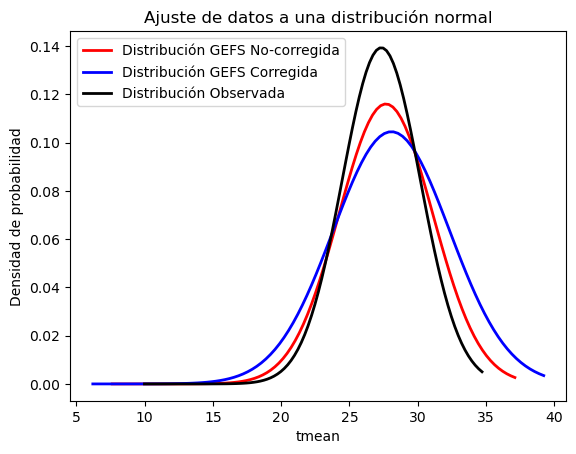

In [7]:
# Ajuste de los datos a una distribución normal
aux =ds_uncal_w2[variable].values.flat
aux_cor =ds_corr_w2[variable].values.flat
aux_era = ds_era[variable].values.flat[~np.isnan(ds_era[variable].values.flat)] 

media_estimada = np.mean(aux)
desviacion_estimada = np.std(aux)
media_estimada_cor = np.mean(aux_cor)
desviacion_estimada_cor = np.std(aux_cor)
media_estimada_era = np.nanmean(aux_era)
desviacion_estimada_era = np.nanstd(aux_era)

x = np.linspace(np.min(aux), np.max(aux), 100)
y = norm.pdf(x, media_estimada, desviacion_estimada)
plt.plot(x, y, 'r-', lw=2, label='Distribución GEFS No-corregida')

x_cor = np.linspace(np.min(aux_cor), np.max(aux_cor), 100)
y_cor = norm.pdf(x, media_estimada_cor, desviacion_estimada_cor)
plt.plot(x_cor, y_cor, 'b-', lw=2, label='Distribución GEFS Corregida')

x_era = np.linspace(np.min(aux_era), np.max(aux_era), 100)
y_era = norm.pdf(x_era, media_estimada_era, desviacion_estimada_era)
plt.plot(x_era, y_era, 'k-', lw=2, label='Distribución Observada')

plt.xlabel(variable)
plt.ylabel('Densidad de probabilidad')
plt.title('Ajuste de datos a una distribución normal')
plt.legend()
plt.show()

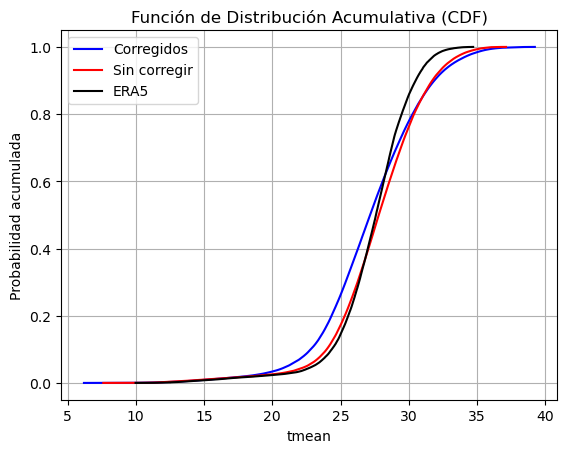

In [8]:
x_ordenados1, cdf1 = calcular_cdf(aux_cor)
x_ordenados2, cdf2 = calcular_cdf(aux)
x_ordenados3, cdf3 = calcular_cdf(aux_era)

# Plotear la CDF
plt.plot(x_ordenados1, cdf1, 'b', label='Corregidos')
plt.plot(x_ordenados2, cdf2, 'r', label='Sin corregir')
plt.plot(x_ordenados3, cdf3, 'k', label='ERA5')
plt.xlabel(variable)
plt.ylabel('Probabilidad acumulada')
plt.title('Función de Distribución Acumulativa (CDF)')
plt.legend()
plt.grid(True)
plt.show()